# Causal Inference with Interference

For this tutorial we'll be looking at a network of US states connected by geographic adjacency. The dependent variable is the number of people infected by a virus after a 30 day period. The treatment is a stay at home order issued by the governor. This provides a fairly intuitive illustration of how treatment and interference works. This tutorial uses simulated data so that treatment can be randomized and so I can make clean assumptions about how spillover works for illustrative purposes. We're going to pretend we don't know the data generating function though.

Here are the basic rules:

1. Within each state the population of infected doubles every 3 days when no stay at home order is issued and there is no interference. 

2. In addition to this natural growth rate within the state, each state experiences spillover effects from neighboring states, further increasing the number of infected

3. When the governor issues a stay at hom order, the natural rate of growth slows, and the spillover effects to other states stops. 

The number of infected after 30 days is a function of the number of infected at the start, whether or not a stay at home order was issued, and the proportion of adjacent states that have also issued stay at home orders. By way of examples, if all the states adjacent to a given state have issued stay at home orders, that state experiences no spillover effects. It can still spill over to other states if it has not issued a stay at home order itself.

In [1]:
# libraries
suppressPackageStartupMessages({
    library(igraph)
    library(dplyr)
    library(usmap)
    library(ggplot2)
})

### Data generation, you can mostly ignore this part

In [2]:
set.seed(123)

edges <- read.csv('state_edges.csv', stringsAsFactors = FALSE)
states <- state.abb[!state.abb %in% list('AK','HI')]
z <- rbinom(length(states), 1, .50)

df <- data.frame(state = states, treatment = z)

g <- graph.data.frame(edges, directed = FALSE, vertices = df)

# get the degree for each node
degree <- degree(g)

# get the number of treated and control neighbors for each node
cn <- sapply(V(g), function(x) {allneighbors = neighbors(g, x) ; length(allneighbors[allneighbors$treatment == 0])})
tn <- sapply(V(g), function(x) {allneighbors = neighbors(g, x) ; length(allneighbors[allneighbors$treatment == 1])})

# proportion of neighbors treated
ptn <- tn/degree
#ptn[is.na(ptn) == TRUE] <- 1 # observations with no neighbors return na, so replace with 1

# function to generate the observed values. We'll pretend we don't know this function.
# Beta is the treatment effect and it slows down the doubling rate
# tau controls the spillover effect
# z is the binary treatment variable
# x is the number of neighbors not treated
# treated turns off spillover effects
natural_growth <- function(beta, z){
    2^(10)/2^(beta * z)
}

spill_over <- function(n, x, tau){
    n * (x * tau)
}

# create the starting value
init <- floor(runif(48, min = 1, max = 5))

# create the observed value. Assumes a doubling time of 3 days with no treatment.
natural_outcome <- init * natural_growth(beta = 2, z = z)
spill_outcome <- spill_over(natural_outcome, x = cn, tau = .05)
y <- natural_outcome + spill_outcome


df <- data.frame(init_cases = init, 
                 cases_1month = round(y), 
                 treatment = z, 
                 neighbors = degree, 
                 treat_neighbors = tn, 
                 control_neighbors = cn,
                 perc_treat_neighbor = ptn)

# Data

Here's a look at our data set. The variables we will work with are:

cases_1month: The total number infected after a 30 day period

treatment: 1 if a stay at home policy has been implemented, 0 otherwise

perc_treat_neighbor: Number of adjacent neighboring states that have issued stay at home orders

In [3]:
head(df)

,init_cases,cases_1month,treatment,neighbors,treat_neighbors,control_neighbors,perc_treat_neighbor
,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>
AL,2,2150,0,4,3,1,0.7500000
AZ,4,1126,1,5,3,2,0.6000000
AR,1,1126,0,6,4,2,0.6666667
CA,2,538,1,3,2,1,0.6666667
CO,4,1178,1,7,4,3,0.5714286
CT,1,1126,0,3,1,2,0.3333333


### And here's a simple map of our simulated network. Light blue are treated states 

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


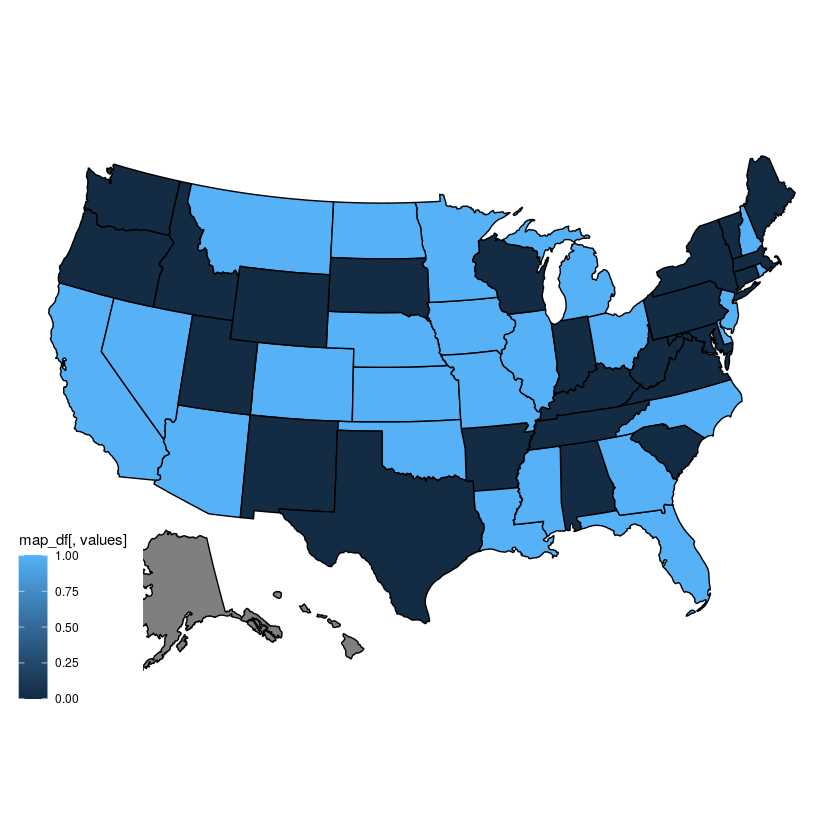

In [4]:
map <- data.frame(state = rownames(df), treatment = df$treatment)
plot_usmap(regions = 'states', data = map, values = 'treatment')

# Process

The test consits of the following steps:

1. Write down the interference model and choose an appropriate test statistic.

2. Remove the hypothesized effects of treatment and interference from the observed outcomes and calculate the test statistic. This is called the uniformity trial and estimates the potential outcome if all units recieved the control.

3. Randomly assign treatments, and then remove the hypothesized treatment effects from the observed outcomes.

4. Calculate the test statistic on the randomized and adjusted outcomes. Repeat these two steps many times.

5. Calculate the p value associated with the tested parameter as the proportion ofrandomized test statistics larger than the observed test statistic

I will walk through each step.

# Step 1: The Interference Model

### Direct Effects

To define the model we start by thinking of what we know about epidemics. We know the rate at which they grow is exponential, and that a common way to think about their growth is the number of days it takes for the population of infected to double. Let's say news reports are saying the population of infected doubled every 3 days without intervention. So a basic model might look like this:

\begin{equation*}
y_i = n \times 2^\frac{days}{3}
\end{equation*}

Where *n* is the number of people infected at a given time, and days is the number of days since n was measured. So if *n* = 5, then six days later the number of infected would have doubled twice and *y* would be 20. We are modeling a 30 day period, meaning the virus will double 10 times. Accordingly we get:

\begin{equation*}
y_i = n \times 2^{10}
\end{equation*}

To counteract this growth, governors closedn on essential businesses and issued stay at home orders. We know this slows the doubling time, be we are unsure by how much. This is the treatment effect, and we will call the unknown size of the treatment efffect $\beta_1$. Since $\beta_1$ only influence the outcome if the treatment effect is applied, we need a term to cancel out its effect when there is no treatment. We'll call this term *z* and it will equal 1 if a state's governor issued stay at home orders and 0 otherwise. Our model now looks like this:

\begin{equation*}
y_i = n \times \frac{2^{10}}{2^{\beta_1 \times z}}
\end{equation*}

Notice how when *z* = 0 the exponent on the denomenator cancels out and the entire denominator goes to 1.

### Spillover Effects

In addition to the direct effect of the treatment, we believe there will be a spill over effect. We assume people in stay at home states stop traveling and thus reduce the spread of the virus. Individuals in stats without the treatment continue to travel and spread the virus at an increased rate. We hypothesize the rate at which spill over occurs is determined by the number neighboring states that have not issued stay at home orders. We don't know the size of this effect, so we estimate that it increases the number of infected by a flat percent for each neighboring state. This percentage is our second parameter $\beta_2$. Our model now looks like this:

\begin{equation*}
(y_i = n \times \frac{2^{10}}{2^{\beta_1 \times z}}) + (\beta_2 \times x \times n \times \frac{2^{10}}{2^{\beta_1 \times z}}) 
\end{equation*}

Where $\beta_2$ is the spillover effect and *x* is the number of neighboring states within the control group. If all neighboring states have stay at home orders then x is zero and the right side term is canceled out, removing the spill over effect. In R, the equation looks like this:

# Step 2: The Uniformity Trial

The uniformity trial is the outcome that would have occured if all observations would have been assigned to the control group. Since we can't actually observe this, we instead remove the hypothesized treatment effects from the observed values. The first step is to hypothesize values for the parameters we are measuring. Ideally you want to search a grid of value, but I'll justpick one value for each parameter. I'll estimate that stay at home orders will reduce the number of times the infected size doubles by 2 to 3 and that the spill over effect increases the infected by 10% per untreated neighbor. Lets define these values.

In [228]:
B1 <- 2.5
B2 <- .1

Now we need to remove the estimated treatment effect from the network. Since nobody is treated, each state will have spill over from all its neighboring nodes. Because we hypothesize spillover is a percentage of the the otherwise infected total, lets first remove all spillover, then we'll remove treatment and add spillover back in as the final step.

In [229]:
# if an observation had no spill over, return the original value. Else, remove the spillover effect.
no_spill <- ifelse(df$control_neighbors == 0, df$cases_1month, df$cases_1month/((df$control_neighbors * B2) + 1))

Now lets remove the treatment effect. Since we estiamte the treatment prevented 2.5 doublings, we double the obvserved values from treated states 2.5 times.

In [230]:
no_treat <- no_spill * 2^(B1 * df$treatment)

Now we add back in the spillover effect, which is the number of infected, plus a percentage of that total depending on the number of neighboring states. This gives us the estimated number of infected with the treatment effect removed.

In [231]:
# round because there are no partially infected people
df$y0 <- round(no_treat + (no_treat * df$neighbors * B2))

Now we calculate the test statistic for the uniformity trial. I'll use the difference of means for now.

In [232]:
mu_treat <- mean(df[df$treatment == 1, 'y0'])
mu_control <- mean(df[df$treatment == 0, 'y0'])

y0_tstat <- mu_control - mu_treat
y0_tstat

[1] -1147.75

# Step 3-6: Randomly Assign Treatments, Calculate the Test Statistic, Repeat. Calculate the p value
### A. The Sharp Null

The sharp null hypothesis is that treatment assignment had no causal effect of any unit. We randomly assign treatment labels and then repeat the same thing we did in the previous section many times.

In [233]:
# get 100 unique permutations of the treatment vector
# ideally you want more trials than this, but I kept the number relatively low for speed
perms <- data.frame(sample(z, 48))
nperms <- 1
while(nperms < 100){
    perms <- cbind(perms, sample(z, 48))
    perms[!(duplicated(perms)), ]
    nperms <- length(perms)
}

In [234]:
#set.seed(123)
random_trials <- c()
for(i in 1:length(perms)){ 

    # now generate a randomized treatment vector and assign it to the random samples
    fdf <- df
    fdf$fake_treat <- perms[,i]
    fdf <- tibble::rownames_to_column(fdf, "state") 

    # create the new graph object to find the number of adjacent treated nodes
    fakeg <- graph.data.frame(edges, directed = FALSE, vertices = fdf)

    # for each node, find the proportion of neighbors that were not treated
    #fdegree <- degree(fakeg)
    fdf$fntn <- sapply(V(fakeg), function(x) {allneighbors = neighbors(fakeg, x) ; length(allneighbors[allneighbors$fake_treat == 0])})
    #fdf$fpntn <- fntn/fdegree
    #fdf$fptn[is.na(fdf$fptn) == TRUE] <- 1 # those with zero neighbors return NA so set their proportion equal to 1

    # Now that we have the randomized treatment and the randomized 
    # proportion of treated neighbors, we can calculate the randomized uniformity trial
    # remove spillover
    fno_spill <- ifelse(fdf$fntn == 0, fdf$cases_1month, fdf$cases_1month/((fdf$fntn * B2) + 1))
    # remove treatment
    fno_treat <- fno_spill * 2^(B1 * fdf$fake_treat)
    # add spillover back in
    fdf$fy0 <- round(fno_treat + (fno_treat * fdf$neighbors * B2))

    # And now we calculate our test statistic for the randomized uniformity trial and return it
    fmu_treat <- mean(fdf[fdf$fake_treat == 1, 'fy0'])
    fmu_control <- mean(fdf[fdf$fake_treat == 0, 'fy0'])
    fy0_tstat <- fmu_control - fmu_treat
    
    #rtstat <- sum(residuals(lm(fy0 ~ fake_treat + fptn, data = fdf))^2) # use RSS as test stat instead of diff of means
    random_trials <- append(random_trials, fy0_tstat)
}

We now have a vector of test statistics from our randomized trials:

In [235]:
random_trials[1:10]

[1] -10276.292  -9604.167  -9331.292  -8903.000  -8868.042 -12184.250
 [7]  -9439.417  -8786.625  -5967.292 -10327.583

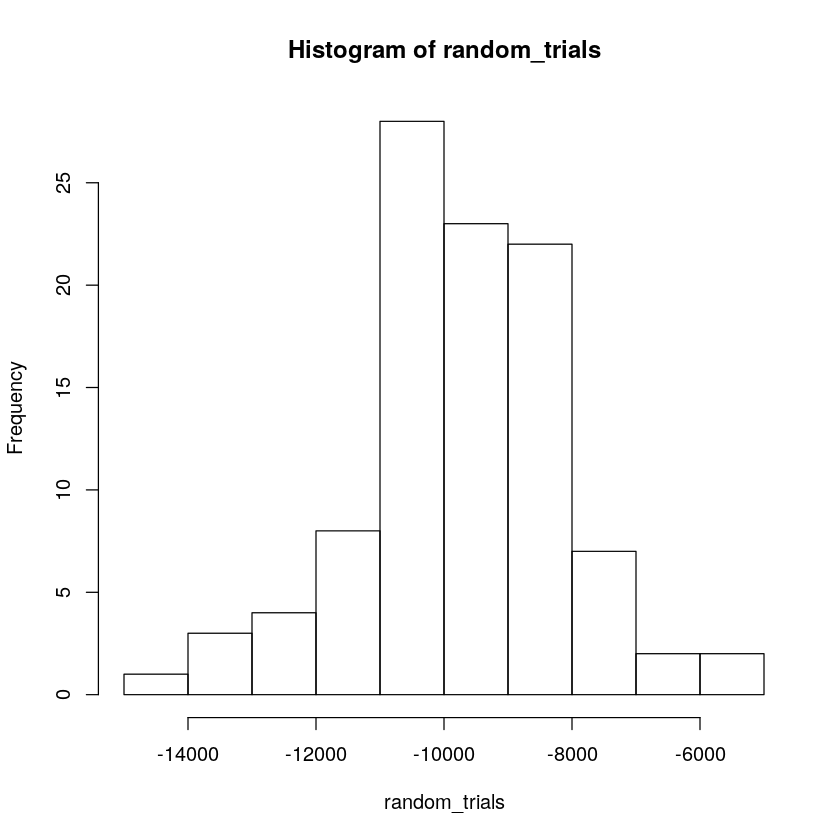

In [236]:
hist(random_trials)

### Calculate the P value

In [238]:
# get the number of random trials less than than what we observed
num <- sum(abs(y0_tstat) < abs(random_trials))
p <- num/100
p

[1] 1

In this instance higher p vlues are associated with greater evidence against the sharp null. The reason for this is because if treatment is having an effect, then removing its effect 

### B. Testing for Interference

To test the spillover effect exclusively we repeat the above process but define our test statistic in terms of control states and the the number of treatment/control states adjacent to them. Lets statrt by removing the spillover effect:

In [239]:
# Set the estimated value of the parameter
B2 <- .1
# if an observation had no spill over, return the original value. Else, remove the spillover effect.
df$y0 <- ifelse(df$control_neighbors == 0, df$cases_1month, df$cases_1month/((df$control_neighbors * B2) + 1))

$\beta_2$ is continuous and the number of adjacent states varies, so a simple difference of means probably isn't the best test statistic. Let's use the the residual sum of squares from a linear model instead.

In [240]:
y0_rss <- sum(residuals(lm(y0 ~ control_neighbors, data = df[df$treatment == 0,]))^2)
y0_rss

[1] 25521275

Now we repeat the randomization process

In [241]:
random_trials <- c()
for(i in 1:length(perms)){

    # now generate a randomized treatment vector and assign it to the random samples
    fdf <- df
    fdf$fake_treat <- perms[,i]
    fdf <- tibble::rownames_to_column(fdf, "state") 

    # create the new graph object to find the number of adjacent treated nodes
    fakeg <- graph.data.frame(edges, directed = FALSE, vertices = fdf)

    # for each node, find the proportion of neighbors that were not treated
    #fdegree <- degree(fakeg)
    fdf$fntn <- sapply(V(fakeg), function(x) {allneighbors = neighbors(fakeg, x) ; length(allneighbors[allneighbors$fake_treat == 0])})
    #fdf$fpntn <- fntn/fdegree
    #fdf$fptn[is.na(fdf$fptn) == TRUE] <- 1 # those with zero neighbors return NA so set their proportion equal to 1

    # Now that we have the randomized treatment and the randomized 
    # proportion of treated neighbors, we can calculate the randomized uniformity trial
    # remove spillover
    fdf$y0 <- ifelse(fdf$fntn == 0, fdf$cases_1month, fdf$cases_1month/((fdf$fntn * B2) + 1))

    # And now we calculate our test statistic for the randomized uniformity trial and return it
    fy0_tstat <- sum(residuals(lm(fdf$y0 ~ fdf$control_neighbors, data = fdf[fdf$treatment == 0,]))^2)
    
    #rtstat <- sum(residuals(lm(fy0 ~ fake_treat + fptn, data = fdf))^2) # use RSS as test stat instead of diff of means
    random_trials <- append(random_trials, fy0_tstat)
}

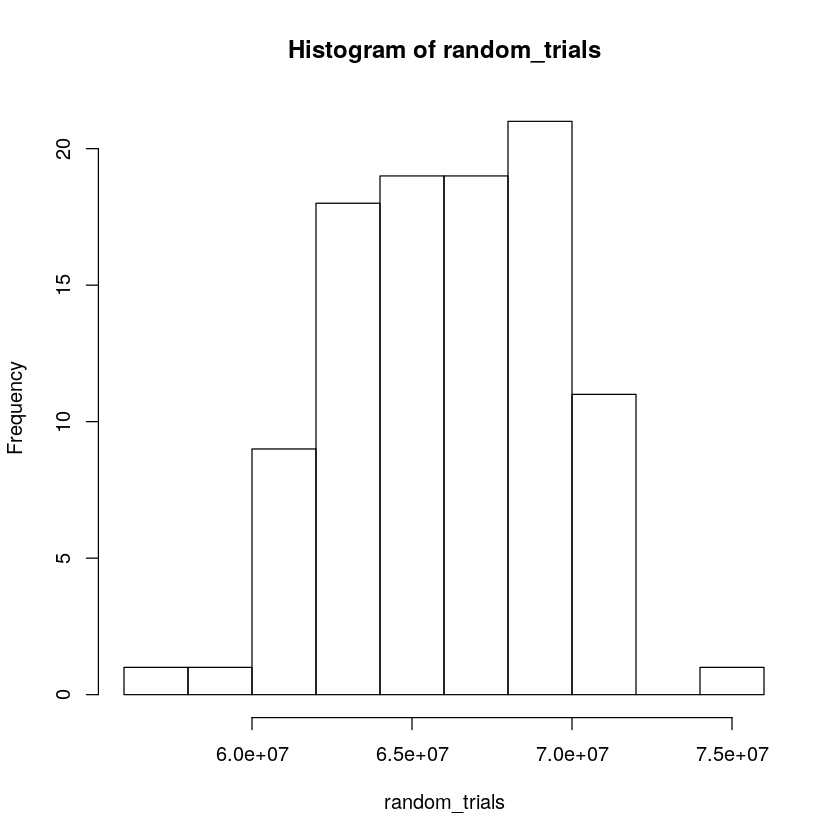

In [242]:
hist(random_trials)

In [243]:
num <- sum(y0_rss < random_trials)
p <- num/100
p

[1] 1

### Calculating a Confidence Interval

To create a confidence interval for the parameter we include any parameter value for which the proportion of the randomized test statistics greater than the observed test statistics are greater than alpha. For example, all parameter values with a p value greater than .05 are inclueded in a 95% confidence interval. Ideally, you'll want to search over a grid of values.